In [244]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.models import vgg16

from PIL import Image
import cv2
import numpy as np
from tqdm import tqdm

import os

import json
import matplotlib.pyplot as plt


import albumentations as A
import albumentations.pytorch as pytorch


In [2]:
from glob import glob

train_imgfiles = glob('data/images/train/*.jpg')

## DATASET

In [3]:
classes = ['traffic sign', 'traffic light', 'car', 'rider', 'motorcycle', 'pedestrian', 'bus', 'truck', 'bicycle', 'other vehicle', 'train', 'trailer', 'other person']

classes_dict = {c : i for i, c in enumerate(classes)}
label_dict = {num : clsname for clsname, num in classes_dict.items()}


In [752]:
class BDDDataset(Dataset) :
    def __init__(self, imgdir, jsonfile, num_grid, num_classes, numBox, transform = None ) :
        super().__init__()
        self.imgdir = imgdir
        self.imgfiles = glob(os.path.join(self.imgdir, '*.jpg'))
        self.imgfiles = sorted(self.imgfiles)
        
        with open(jsonfile, 'r') as f :
            json_infos = json.load(f)
        self.json_infos = sorted(json_infos, key = lambda x : x['name'])

        ## make sure json information and imgfile are matched
        for info, imgfile in tqdm(zip(self.json_infos, self.imgfiles), desc = 'validate json and image matching...') :
            assert os.path.basename(imgfile) == info['name']

        self.num_grid = num_grid
        self.num_classes = num_classes
        self.numBox = numBox

        self.transform = transform
        

    def __getitem__(self, idx) :
        imgfile = self.imgfiles[idx]
        json_info = self.json_infos[idx]

        json_info = json_info['labels'] if 'labels' in json_info.keys() else []

        image = plt.imread(imgfile) / 255.
        
        
        bboxes = []
        labels = []
        for info in json_info :
            label = info['category']
            coord = info['box2d']
            x, y = coord['x'], coord['y']
            w, h = coord['w'], coord['h']
            label = classes_dict[label]
            
            bboxes.append([x,y,w,h])
            labels.append(label)

        if self.transform :
            transformed = self.transform(image = image, bboxes = bboxes, label = labels)
            image = transformed['image']
            bboxes = transformed['bboxes']
            labels = transformed['label']
        

        H, W = image.shape[1:]
        label_grid = self.encode(bboxes, labels, H, W)

        return torch.tensor(image, dtype = torch.float32), torch.tensor(label_grid, dtype = torch.float32)
        

    def __len__(self) :
        return len(self.imgfiles)


    def encode(self, bboxes, labels, H, W) :
        label_grid = np.zeros((self.num_grid, self.num_grid, self.numBox * 5 + self.num_classes ), np.float32)
        grid_idxbox = np.zeros((self.num_grid, self.num_grid), np.uint8)
        label_box = np.full_like(grid_idxbox, -1) # grid cell당 하나의 class만 포함할 수 있다. 이미 grid안에 label값이 들어가있다면, continue.

        for bbox, label in zip(bboxes, labels) :

            x, y, w, h = bbox


            assert H == W, f'yolov1 takes only square image size. H = {H}, W = {W}'
            gridsize = 1 / self.num_grid

            grid_xidx = min(max(0, int(x // gridsize)), self.num_grid - 1) # there are cases center of bbox located at the endpoint
            grid_yidx = min(max(0, int(y // gridsize)), self.num_grid - 1) 

            ## normalize respect to the grid point
            grid_x0 = gridsize * grid_xidx
            grid_y0 = gridsize * grid_yidx

            normalized_x = (x - grid_x0) / gridsize
            normalized_y = (y - grid_y0) / gridsize

            boxnum = grid_idxbox[grid_yidx][grid_xidx]

            ## 하나의 grid cell은 하나의 class만 포함할 수 있다.
            if label_box[grid_yidx][grid_xidx] == -1 : # grid cell에 아무런 값이 들어가지 않은 경우, label을 넣어준다.
                label_box[grid_yidx][grid_xidx] = label

            elif label_box[grid_yidx][grid_xidx] == label : # label값이 이미 들어가있을 경우, 같은 클래스에 대한 값만 넣어준다.
                label_grid[grid_yidx, grid_xidx, self.numBox*5 + label] = 1.0
                if boxnum < self.numBox :
                    # 최대 self.numBox만큼만 넣는다.
                    # put into the grid
                    label_grid[grid_yidx, grid_xidx, boxnum*5 : boxnum*5 + 5 ] = [normalized_x, normalized_y, w, h, 1] 
                    grid_idxbox[grid_yidx][grid_xidx] += 1
                
            

        return label_grid
        


In [753]:
data_transform = A.Compose([
    A.geometric.resize.SmallestMaxSize(max_size = 446),
    # A.RandomCrop(width = 446, height = 446),
    
    A.RandomCrop(width = 446, height = 446, always_apply = True, p = 1.0),
    
    A.PadIfNeeded(min_width = 446, min_height = 446, border_mode=None),
    pytorch.transforms.ToTensorV2(),
], bbox_params = A.BboxParams(format = 'yolo', label_fields = ['label'], min_visibility = 0.8))


In [589]:
dataset = BDDDataset(imgdir = 'data/images/val', 
           jsonfile = 'data/label/yolo_det_val.json', 
           num_grid = 7, 
           num_classes = 13, 
           numBox = 2 , 
           transform = data_transform )


validate json and image matching...: 10000it [00:00, 1796891.44it/s]


In [590]:
idx = 5050
img, label_grid = dataset.__getitem__(idx)

/var/folders/g3/glr70r5n6z5gjn30xdr24fhc0000gn/T/ipykernel_86649/3549377029.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype = torch.float32), label_grid


In [593]:
img.shape

torch.Size([3, 446, 446])

In [208]:
# for j, label_row in enumerate(label_grid) :
#     for i, label in enumerate(label_row) :
#         print(j,i)
#         print(label, end = '\n')

## VISUALIZE

In [597]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # white


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=1):
    """Visualizes a single bounding box on the image"""
    img_h, img_w = img.shape[:2]

    x, y, w, h = bbox
    x_min, x_max, y_min, y_max = x - w/2, x + w/2, y - h/2, y + h/2
    x_min = int(img_w * x_min)
    x_max = int(img_w * x_max)
    y_min = int(img_h * y_min)
    y_max = int(img_h * y_max)



   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids):
    if type(image) == torch.Tensor :
        image = image.permute(1,2,0).detach().cpu().numpy()
    else :
        image = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

def visualize_gridbbox(img, label_grid, numBox = 2, color = BOX_COLOR, thickness = 1) :
    H, W = img.shape[:2]
    
    if type(img) == torch.Tensor :
        copy_img = img.permute(1,2,0).detach().cpu().numpy().copy()
    else :
        copy_img = img.copy()
    assert H == W, 'image size should be same.'
    num_grid, _, info_length = label_grid.shape

    gridsize = H // num_grid

    for yidx in range(num_grid) :
        for xidx in range(num_grid) :
            
            for box_idx in range(numBox) : 

                x0, y0 = xidx, yidx
                x_center, y_center, w, h = label_grid[yidx, xidx, box_idx * 5 : box_idx * 5 + 4]
                x_center = int((x_center + x0) * gridsize)
                y_center = int((y_center + y0) * gridsize)

                xmin = int(x_center - w * W / 2)
                ymin = int(y_center - h * H / 2)
                xmax = int(x_center + w * W / 2)
                ymax = int(y_center + h * H / 2)

                cv2.rectangle(copy_img, (xmin, ymin), (xmax, ymax), color = color, thickness = thickness)
    
    return copy_img
    


    
    


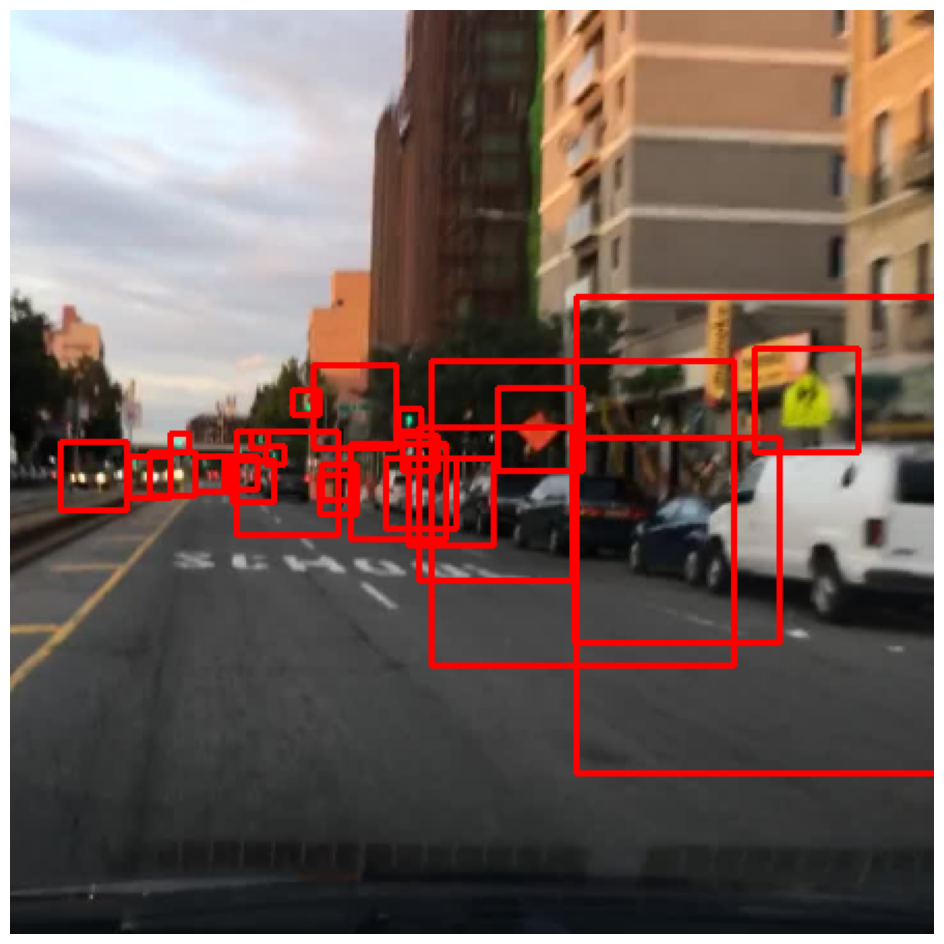

In [86]:
visualize(img, bboxes, labels)

## MODEL

In [213]:
class YOLO(nn.Module):
    def __init__(self, VGG16, num_grids = 7, numBox = 2, num_classes = 13):
        '''
        VGG16 : backbone network
        num_grids : # of grids to divde an image, make sure to be dividable with image size
        numBox : number of boxes per grid
        num_classes : # of classes. In BDD, there are 13 classes
        '''
        super().__init__()

        self.backbone = VGG16
        self.num_grids = num_grids
        self.numBox = numBox
        self.num_classes = num_classes


        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = 512,out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(negative_slope = 0.1),
            nn.Conv2d(in_channels = 1024,out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(negative_slope = 0.1),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels = 1024,out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(negative_slope = 0.1),
            nn.Conv2d(in_channels = 1024,out_channels = 1024, kernel_size = 3, padding = 1),
            nn.LeakyReLU(negative_slope = 0.1),
            nn.Flatten()
        )
        self.linear = nn.Sequential(
            nn.Linear((num_grids**2) * 1024, 4096),
            nn.LeakyReLU(negative_slope = 0.1),
            nn.Dropout(),
            nn.Linear(4096, (num_grids**2)*(numBox*5 + num_classes)) # 5 = len([x,y,w,h,pr(obj)])
        )

        # 가중치 초기화
        for m in self.conv.modules():
    	    if isinstance(m, nn.Conv2d) :
		        nn.init.normal_(m.weight, mean=0, std=0.01)
                
        for m in self.linear.modules():
        	if isinstance(m, nn.Linear) :
                 nn.init.normal_(m.weight, mean=0, std=0.01)
                

    # 정전파 
    def forward(self, x):
        out = self.backbone(x)
        out = self.conv(out)
        out = self.linear(out)
        out = torch.reshape(out, (-1 ,self.num_grids, self.num_grids, 
                                        self.numBox*5 + self.num_classes))
        return out

In [621]:
"""
Implementation of Yolo (v1) architecture
with slight modification with added BatchNorm.
"""

import torch
import torch.nn as nn

""" 
Information about architecture config:
Tuple is structured by (kernel_size, filters, stride, padding) 
"M" is simply maxpooling with stride 2x2 and kernel 2x2
List is structured by tuples and lastly int with number of repeats
"""

architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))


class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        # In original paper this should be
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

In [622]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = Yolov1(split_size = 7, num_boxes = 2, num_classes = 13)

In [623]:
## dataloader
dataloader = DataLoader(dataset, batch_size = 4)
img, label_grid = next(iter(dataloader))

img = img.to(device)
label_grid = label_grid.to(device)

/var/folders/g3/glr70r5n6z5gjn30xdr24fhc0000gn/T/ipykernel_86649/3549377029.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype = torch.float32), label_grid


In [624]:
output = model(img)

In [625]:
num_grid = 7
num_boxes = 2
num_classes = 13

output = output.reshape(-1, num_grid, num_grid, (num_boxes * 5 + num_classes))



## IoU

In [626]:
def IoU(pred, gt) :
    '''Intersection over Union'''

    pred_x_center = pred[..., 0:1]
    pred_y_center = pred[..., 1:2]
    pred_w = pred[..., 2:3]
    pred_h = pred[..., 3:4]

    gt_x_center= gt[..., 0:1]
    gt_y_center = gt[..., 1:2]
    gt_w = gt[..., 2:3]
    gt_h = gt[..., 3:4]


    pred_x1 = pred_x_center - pred_w / 2
    pred_y1 = pred_y_center - pred_h / 2

    pred_x2 = pred_x_center + pred_w / 2
    pred_y2 = pred_y_center + pred_h / 2



    gt_x1 = gt_x_center - gt_w / 2
    gt_y1 = gt_y_center - gt_h / 2

    gt_x2 = gt_x_center + gt_w / 2
    gt_y2 = gt_y_center + gt_h / 2

    x1 = torch.max(pred_x1, gt_x1)
    y1 = torch.max(pred_y1, gt_y1)

    x2 = torch.min(pred_x2, gt_x2)
    y2 = torch.min(pred_y2, gt_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    total_area = ((pred_x2 - pred_x1) * (pred_y2 - pred_y1)) + ((gt_x2 - gt_x1) * (gt_y2 - gt_y1))

    return intersection / (total_area - intersection + 1e-6) # add buffer



    

In [627]:
pred = torch.randn((4,7,7,23))
gt = torch.randn((4,7,7,23))

IoU(pred, gt).shape

torch.Size([4, 7, 7, 1])

In [628]:
## test case

## 1. 0.25 overlap
pred = torch.tensor([[0.20, 0.20, 0.5, 0.5]])
gt = torch.tensor([[0.45, 0.45, 0.5, 0.5]])
print(f'answer should be 1/7. output is {IoU(pred, gt)}')

## 2. No overlap
pred = torch.tensor([[0.1, 0.1, 0.3, 0.3]])
gt = torch.tensor([[0.7, 0.7, 0.2, 0.2]])
print(f'answer should be 0. output is {IoU(pred, gt)}')

## 3. gt embrace pred. gt>pred
pred = torch.tensor([[0.3, 0.3, 0.3, 0.3]])
gt = torch.tensor([[0.1, 0.1, 0.8, 0.8]])
print(f'answer should be 0.1406. output is {IoU(pred, gt)}')

## 4. pred embrace gt. gt<pred
pred = torch.tensor([[0.1, 0.1, 0.8, 0.8]])
gt = torch.tensor([[0.3, 0.3, 0.3, 0.3]])
print(f'answer should be 0.1406. output is {IoU(pred, gt)}')



answer should be 1/7. output is tensor([[0.1429]])
answer should be 0. output is tensor([[0.]])
answer should be 0.1406. output is tensor([[0.1406]])
answer should be 0.1406. output is tensor([[0.1406]])


## NMS

In [708]:
def nms(bboxes, threshold, iou_threshold) :
    '''
    bboxes : [[x,y,w,h,c], ]. c = confidence score
    threshold : confidence thresholds
    iou_threshold : if boxes overlap over iou_threshold, eliminate from the candidates
    '''
    bboxes = [box for box in bboxes if box[4] > threshold]
    # sort by highest confidence
    bboxes = sorted(bboxes, key = lambda x : x[4]) 

    bboxes_after_nms = []
    while bboxes :
        chosen_box = bboxes.pop()

        bboxes = [
            box
            for box in bboxes
            if box[4] != chosen_box[4] \
                or IoU(np.array(box), np.array(chosen_box)) < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms






## LabelGRID to Predictions

In [699]:
## convert labelgrid into (bboxes, confidence_scores, labels)

def convert_prediction(label_grid, num_bboxes, num_classes) :
    '''
    operations are grid units.
    
    MAKE SURE label_grid is NOT BATCHWISE.

    label_grid : output of the model. (num_grid x num_grid x (num_bboxes * 5 + num_classes ) 
    num_bboxes : maximum number of boxes per grid cell
    num_classes : # of classes
    '''

    num_grid, num_grid, seq_length = label_grid.shape

    # get class index with highest probabilities
    classlist_grid = label_grid[..., num_bboxes*5 : ]
    max_probability_class_grid = torch.argmax(classlist_grid, -1)

    # select coordinates and confidence scores with highest probability per grid cell
    coords_grid = label_grid[..., :num_bboxes*5]
    
    confidence_score_idx = [5*(i+1)-1 for i in range(num_bboxes)] # select only the confidence score indexes
    max_confidence_grid, idx_grid = torch.max(coords_grid[..., confidence_score_idx], keepdim= True, dim = -1)

    ## idx_grid refers to the index of box information with the highest confidence score. since [x,y,w,h, conf_score]. we divide confidence score divided by 5.
    coords_idx_grid = torch.cat([(idx_grid // 5) + i for i in range(5)], -1) 

    xywh_grid = torch.gather(coords_grid, -1, coords_idx_grid)

    ## convert ratio respect to the image size => add y0, x0 coordinates. (y0, x0) differ by grid cell.
    gridsize = 1 / num_grid
    bboxes = []
    for j in range(num_grid) :
        for i in range(num_grid) :
            y0 = gridsize * j
            x0 = gridsize * i
            x, y, w, h, confidence_score = xywh_grid[j][i].detach().cpu().numpy()

            bboxes.append([
                            x + x0, y + y0, w, h, confidence_score
                            ])

    

    return bboxes







In [700]:
## test
batch_size = 4
num_grid = 7
num_bboxes = 2
num_classes = 13
samp_label_grid = torch.randn((num_grid, num_grid, (num_bboxes * 5 + num_classes)))

bboxes = convert_prediction(samp_label_grid, num_bboxes, num_classes)


len(bboxes)


49

## LOSS

In [760]:
class YOLOLoss(nn.Module) :
    def __init__(self, lambda_coord = 5, lambda_noobj = 0.5, num_grid = 7, numBox = 2) :
        super().__init__()

        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.num_grid = num_grid
        self.numBox = numBox
        self.MSEloss = nn.MSELoss(reduction = 'mean')

        

    def forward(self, output, target) :
        '''
        for num_classes = 13, and numBox = 2,
        each grid cell contains 
        [[x,y,w,h,pr(obj), x,y,w,h,pr(obj), 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,],]

        '''
        batch_size = output.size(0)
        
        obj_loss = 0
        noobj_loss = 0
        coordinate_loss = 0
        # class loss is considered per grid cell. We loop over gt boxes of the gridcells.

        for gtbox_idx in range(self.numBox) :

            gt_coords = target[..., gtbox_idx*5 : (gtbox_idx+1)*5]

            identity_obj = gt_coords[..., -1:] # to remain the last dimension

            total_pred_coords = output[..., :self.numBox*5] # batch_size, grid, grid, (x,y,w,h,pr(obj) )

            # ious = torch.zeros((batch_size, self.num_grid, self.num_grid, self.numBox))
            ious = torch.zeros_like(total_pred_coords[..., :self.numBox])

            ## Box 갯수만큼 IoU를 계산
            for box_idx in range(self.numBox) : # select only one box with the highest IoU
                pred_coords = total_pred_coords[..., box_idx*5 : (box_idx + 1)*5]
                ious[..., box_idx:box_idx+1] = IoU(pred_coords, gt_coords)


            _, iou_mask = torch.max(ious, axis = -1, keepdim = True) # torch.max return max values of the selected axis and the indices of them. we are going to use these indices to select the highest IoU bboxes
            
            # iou mask turn into index slices
            iou_mask = torch.cat([iou_mask + i for i in range(5)], dim = -1)

            # print(total_pred_coords[iou_mask * 5 : (iou_mask+1) * 5].shape)


            


            selected_pred_coords = torch.gather(total_pred_coords, -1, iou_mask) # (B, grid, grid, 1)

            # object loss calculated for the box with the highest IoU
            # obj_loss = self.calculate_object_loss(selected_pred_coords[..., -1], gt_coords[], identity_obj)
            # no_obj loss calculated for entire boxes compare with the gt
            # no_obj_loss = self.calculate_no_obj_loss(total_pred_coords, gt_coords, identity_obj )


            ###############
            # OBJECT LOSS #
            ###############


            obj_loss += self.MSEloss(identity_obj * selected_pred_coords[..., -1:], identity_obj)

            ##################
            # NO_OBJECT LOSS #
            ##################
            # penalize if no object gt grid predicts bbox
            noobj_loss += self.MSEloss((1 - identity_obj) * selected_pred_coords[..., -1:], identity_obj)


            ###################
            # COORDINATE LOSS #
            ###################
            coord_xy_loss, coord_wh_loss = self.calculate_boxloss(selected_pred_coords, gt_coords, identity_obj)
            coordinate_loss += coord_xy_loss + coord_wh_loss

        ##############
        # CLASS LOSS #
        ##############
        # if any gt object exists, the first grid cell pr(object) = 1. We don't want to take account for no object box' class.
        obj_exists = target[..., 5:6]
        class_loss = self.MSEloss(obj_exists * output[..., self.numBox*5 : ], obj_exists * target[..., self.numBox*5 : ])


        loss = (coordinate_loss * self.lambda_coord \
                + obj_loss  \
                + noobj_loss * self.lambda_noobj \
                + class_loss)

        return loss



    def calculate_boxloss(self, pred, gt, identity_obj) :
        '''
        pred : (B x num_grid x num_grid x 5). selected with the highest IoU
        gt : (B x num_grid x num_grid x 5)
        identity_obj : whether object exists or not

        '''

        ## COORDINATE LOSS
        # (x - xpred)**2 + (y - ypred) ** 2
        coord_xy_loss = self.MSEloss(identity_obj * torch.square(gt[..., :2]), pred[..., :2]) 
        # (w**(1/2) - wpred**(1/2)) + (h**(1/2) - hpred(1/2))
        coord_wh_loss = self.MSEloss(identity_obj * torch.sign(pred[..., 2:4]) * torch.sqrt(torch.abs(pred[..., 2:4])), torch.sqrt(gt[..., 2:4] + 1e-9))

        return coord_xy_loss, coord_wh_loss
        





## TRAIN CONFIGURATION

In [666]:
NUM_EPOCHS = 135
BATCH_SIZE = 64
MOMENTUM = 0.9
DECAY = 5e-4
LR = [1e-2, 1e-3, 1e-4] # 1e-2 : 75ep , 1e-3 : 30ep, 1e-4 : 30 epochs
DROPOUT = 0.5
## Data Augmentation : random scaling,translations of up to 20% of the original imgsize, random exposure, saturation by up to 1.5x in HSV color space


## Implement Pytorch Lightning

In [716]:
import pytorch_lightning as pl
from torch import optim

In [746]:


"""
Implementation of Yolo (v1) architecture
with slight modification with added BatchNorm.
"""

import torch
import torch.nn as nn

""" 
Information about architecture config:
Tuple is structured by (kernel_size, filters, stride, padding) 
"M" is simply maxpooling with stride 2x2 and kernel 2x2
List is structured by tuples and lastly int with number of repeats
"""

architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))


class Yolov1(pl.LightningModule):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)
        self.num_grid = num_grid
        self.numBoxes = num_boxes
        self.num_classes = num_classes
        
        self.yolo_loss = YOLOLoss(lambda_coord = 5, lambda_noobj = 0.5, num_grid = 7, numBox = 2)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))


    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, num_grid, num_boxes, num_classes):
        
        S, B, C = num_grid, num_boxes, num_classes

        # In original paper this should be
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

    def configure_optimizers(self) :
        optimizer = optim.Adam(self.parameters(), lr = 1e-3)
        return optimizer

    def training_step(self, batch, batch_idx) :
        img_batch, label_grid = batch
        img_batch = img_batch.to(device)
        label_grid = label_grid.to(device)

        pred = self.forward(img_batch)
        pred = pred.reshape(-1, self.num_grid, self.num_grid, (self.numBoxes * 5 + self.num_classes))

        loss = self.yolo_loss(pred, label_grid)
        self.log('train_loss', loss)
        return loss



In [761]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [762]:
model = Yolov1(num_grid = 7, num_boxes = 2, num_classes = 13).to(device)


In [763]:
data_transform = A.Compose([
    A.geometric.resize.SmallestMaxSize(max_size = 446),
    # A.RandomCrop(width = 446, height = 446),
    
    A.RandomCrop(width = 446, height = 446, always_apply = True, p = 1.0),
    
    A.PadIfNeeded(min_width = 446, min_height = 446, border_mode=None),
    pytorch.transforms.ToTensorV2(),
], bbox_params = A.BboxParams(format = 'yolo', label_fields = ['label'], min_visibility = 0.8))


dataset = BDDDataset(imgdir = 'data/images/val', 
           jsonfile = 'data/label/yolo_det_val.json', 
           num_grid = 7, 
           num_classes = 13, 
           numBox = 2 , 
           transform = data_transform )

train_dataloader = DataLoader(dataset)

Epoch 0:   0%|          | 0/10000 [18:16:12<?, ?it/s]


validate json and image matching...: 10000it [00:00, 1751275.16it/s]


In [764]:
img_batch, labelgrid_batch = next(iter(train_dataloader))

type(labelgrid_batch)

/var/folders/g3/glr70r5n6z5gjn30xdr24fhc0000gn/T/ipykernel_86649/1331464771.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype = torch.float32), torch.tensor(label_grid, dtype = torch.float32)


torch.Tensor

In [765]:
trainer = pl.Trainer(max_epochs = 1, accelerator = 'gpu')
trainer.fit(model = model, train_dataloaders = train_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type       | Params
-----------------------------------------
0 | darknet   | Sequential | 60.2 M
1 | fcs       | Sequential | 25.4 M
2 | yolo_loss | YOLOLoss   | 0     
-----------------------------------------
85.6 M    Trainable params
0         Non-trainable params
85.6 M    Total params
342.468   Total estimated model params size (MB)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|          | 0/10000 [00:00<?, ?it/s] 

/var/folders/g3/glr70r5n6z5gjn30xdr24fhc0000gn/T/ipykernel_86649/1331464771.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype = torch.float32), torch.tensor(label_grid, dtype = torch.float32)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/torch/autograd/__init__.py:200: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678454847243/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0:  60%|█████▉    | 5950/10000 [18:24<12:31,  5.39it/s, v_num=8]

RuntimeError: Missing folder: /Users/silvercity/Documents/OBJECT_DETECTION/lightning_logs/version_8.

Add Experiments Management Tools

- Tensorboard
- mlflow
- weights & biases
